In [1]:
import pandas as pd
import numpy as np
import re, string

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('train_cv_target.csv')

In [109]:
test = pd.read_csv('../data/test_eng.csv')

## Create Features

In [6]:
def strip(x, n):
    return x.strip()[:n].strip()

def add_CPV_features(df, split_type=1):
    df['CPV2017'] = df['CPV2017'].apply(lambda x: '00000000-0' if strip(x, 10) == '-' else x)
    
    if split_type == 1:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: x.strip()[:2])
        df['CPV_group'] = df['CPV2017'].apply(lambda x: x.strip()[2:3])
        df['CPV_class'] = df['CPV2017'].apply(lambda x: x.strip()[3:4])
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: x.strip()[4:5])
    else:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: x.strip()[:2])
        df['CPV_group'] = df['CPV2017'].apply(lambda x: x.strip()[:3])
        df['CPV_class'] = df['CPV2017'].apply(lambda x: x.strip()[:4])
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: x.strip()[:5])
    
    df['CPV_desc'] = df['CPV2017'].apply(lambda x: x[11:])
    df['CPV_desc'] = df['CPV_desc'].apply(lambda x: "NO DESC" if len(x.strip()) < 2 else x )
    
    df['Organizer'] = df['Organizer'].apply(lambda x: x.lower())
    df['Organizer_railroad'] = df['Organizer'].apply(lambda x: 1 if 'залізниц' in x else 0)
    df['Organizer_ministry'] = df['Organizer'].apply(lambda x: 1 if 'міністерств' in x else 0)
    df['Organizer_komun'] = df['Organizer'].apply(lambda x: 1 if 'комунальне підприємство' 
                                                  in x else 0)
    df['Organizer_edu'] = df['Organizer'].apply(lambda x: 1 if 'освіт' in x else 0)
    
    return df

In [8]:
data = add_CPV_features(data)

In [110]:
test = add_CPV_features(test)

In [9]:
train = data[data.train_val=='train']
val = data[data.train_val=='val']

In [10]:
def rmsle(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [90]:
data_filtered = data[data['LotStatus'] == 'Завершено лот закупівлі'][data['TenderStatus'] == 'complete']

/home/jt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


---

In [12]:
import tokenize_uk

In [93]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LinearRegression, Ridge, SGDRegressor
from sklearn.pipeline import Pipeline
import eli5
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

In [14]:
def preprocess(text):
    return ' '.join(tokenize_uk.tokenize_words(text)).lower()

In [72]:
rmsle_scorer = make_scorer(rmsle)

In [70]:
text_features = [
    'Tender',
    'LotDescr',
    'Organizer',
    'CPV_desc'
]

In [89]:
model = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer(ngram_range=(1, 1), min_df=10, max_features=5000)),
#     ("lr", LinearRegression()) # linear is better
    ("lr", Ridge(solver='auto', fit_intercept=True, alpha=0.4, max_iter=250, normalize=False, tol=0.01))
])

In [73]:
for feature in text_features:
    print(feature)
    featrure_name = feature + '_text_prep'
    data[featrure_name] = data[feature].map(preprocess)
    
    scores = cross_val_score(model, data[featrure_name], data['counts'], scoring=rmsle_scorer)
    print(scores, np.mean(scores))

Tender
[0.36090807 0.36292913 0.36241   ]
LotDescr
[0.37196491 0.37386739 0.37319962]
Organizer
[0.36876862 0.37049477 0.36966456]
CPV_desc
[0.36464436 0.3669872  0.36645737]


In [94]:
for feature in text_features:
    print(feature)
    featrure_name = feature + '_text_prep'
    
    y_pred = cross_val_predict(model, data[featrure_name], data['counts'])
    data['prediction_' + feature] = y_pred
#     print(scores, np.mean(scores))

Tender
LotDescr
Organizer
CPV_desc


In [98]:
data[['unique_id', 'prediction_Tender', 'prediction_LotDescr', 'prediction_Organizer', 'prediction_CPV_desc']].to_csv('text_prediction.csv', index=False)

In [111]:
for feature in text_features:
    print(feature)
    featrure_name = feature + '_text_prep'
    model.fit(data[featrure_name],  data['counts'])
    test[featrure_name] = test[feature].map(preprocess)
    y_pred = model.predict(test[featrure_name])
    test['prediction_' + feature] = y_pred

Tender
LotDescr
Organizer
CPV_desc


In [120]:
test[['unique_id', 'prediction_Tender', 'prediction_LotDescr', 'prediction_Organizer', 'prediction_CPV_desc']].to_csv('text_prediction_test.csv', index=False)

## Analysis

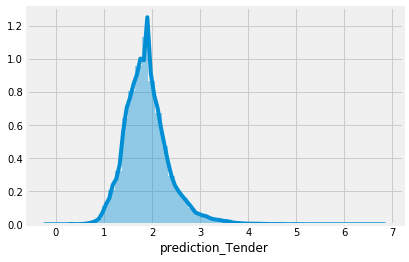

In [119]:
sns.distplot(data['prediction_Tender'])

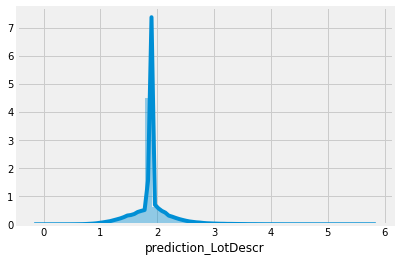

In [113]:
sns.distplot(data['prediction_LotDescr'])

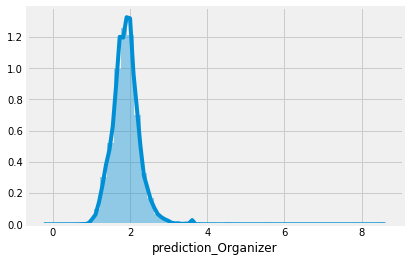

In [114]:
sns.distplot(data['prediction_Organizer'])

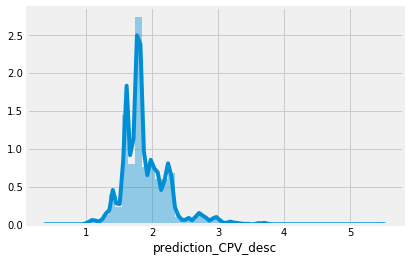

In [118]:
sns.distplot(data['prediction_CPV_desc'])

In [103]:
eli5.explain_weights(logistic_tfidf_base)

Explanation(estimator="Pipeline(memory=None,\n     steps=[('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',\n        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n        lowercase=True, max_df=1.0, max_features=5000, min_df=10,\n        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth... fit_intercept=True, max_iter=250,\n   normalize=False, random_state=None, solver='auto', tol=0.01))])", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='картр', weight=3.6900185940222308, std=None, value=None), FeatureWeight(feature='антитерористичної', weight=3.6327023942676946, std=None, value=None), FeatureWeight(feature='вивченням', weight=3.5445814610680175, std=None, value=None), FeatureWeight(feature='метилпреднізолон', weight=3.1412610401028167, std=None, value=None), FeatureWeight(feature='бульби', weight=3.1196257308237416, std=None, value=None), FeatureWeight(feature='завершеного', weight=3.1033095303943714, std=None, value=None), FeatureWeight(feature='сахароза', weight=2.9944980841182995, std=None, value=None), FeatureWeight(feature='пральний', weight=2.88606100942876, std=None, value=None), FeatureWeight(feature='гісса', weight=2.8757914723130034, std=None, value=None), FeatureWeight(feature='_лот', weight=2.7073193005533644, std=None, value=None), FeatureWeight(feature='світлодіодні', weight=2.69680880209584, std=None, value=None), FeatureWeight(feature='відеоспостереженням', weight=2.6712775064305587, std=None, value=None), FeatureWeight(feature='активоване', weight=2.6386345517056125, std=None, value=None), FeatureWeight(feature='2224', weight=2.472232257567365, std=None, value=None), FeatureWeight(feature='футболки', weight=2.451716486959266, std=None, value=None), FeatureWeight(feature='постільної', weight=2.3280405229341112, std=None, value=None)], neg=[FeatureWeight(feature='поглибленим', weight=-2.901413888395674, std=None, value=None), FeatureWeight(feature='міжквартальних', weight=-2.3576997034693274, std=None, value=None), FeatureWeight(feature='арештованого', weight=-2.3076885371522793, std=None, value=None), FeatureWeight(feature='хустинки', weight=-2.294939542512415, std=None, value=None)], pos_remaining=2267, neg_remaining=2714), proba=None, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [104]:
text = """
    картриджі для лазерних принтерів
"""

In [105]:
eli5.explain_prediction_sklearn(
    logistic_tfidf_base.steps[1][1],
    preprocess(text),
    vec=logistic_tfidf_base.steps[0][1],
    feature_names=logistic_tfidf_base.steps[0][1].get_feature_names(), )

Explanation(estimator="Ridge(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=250,\n   normalize=False, random_state=None, solver='auto', tol=0.01)", description=None, error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.8606812661675995, std=None, value=1.0), FeatureWeight(feature='картриджі', weight=0.734557544935243, std=None, value=0.53242740971495), FeatureWeight(feature='лазерних', weight=0.6693320889976324, std=None, value=0.6228293160672822), FeatureWeight(feature='принтерів', weight=0.39096635221366577, std=None, value=0.5286963129610276)], neg=[FeatureWeight(feature='для', weight=-0.03526533418946516, std=None, value=0.22155113426206016)], pos_remaining=0, neg_remaining=0), proba=None, score=3.6202719181246756, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='картриджі для лазерних принтерів', spans=[('картриджі', [(0, 9)], 0.734557544935243), ('для', [(10, 13)], -0.03526533418946516), ('лазерних', [(14, 22)], 0.6693320889976324), ('принтерів', [(23, 32)], 0.39096635221366577)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.8606812661675995, std=None, value=1.0), FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=1.7595906519570759, std=None, value=None)], neg=[], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [107]:
train[train['text_prep'].str.contains('картр')][['text_prep', 'counts']]

text_prep  counts
233                      картриджі для лазерних принтерів       7
447                        картриджі для принтерів та мфу       1
687     технічне обслуговування і ремонт офісної техні...       1
757     фотокопіювальне та поліграфічне обладнання для...       1
758     фотокопіювальне та поліграфічне обладнання для...       2
825     картриджі рембо - мікс , рембо - джет , змінна...       2
953       послуги з заправлення та відновлення картриджів       3
1010                                  заправка картриджів       1
1011                                  заправка картриджів       1
1012                                  заправка картриджів       1
1013                                  заправка картриджів       1
1707    технічне обслуговування і ремонт офісної техні...       2
2080    послуги з обслуговування та технічного ремонту...       3
2141    послуги з заправки та відновлення картриджів д...       5
2187    дк 021 : 2015 ( cpv ) – 50310000-1 технічне об...       2
2190    придбання багатофункціонального пристрою та ка...       3
2396                   відновлення та заправка картриджів       1
2445    технічне обслугововування комп " ютерів , запр...       5
2674    код 30230000-0 дк 021 : 2015 - комп’ютерне обл...       1
2887    технічне обслуговування і ремонт офісної техні...       1
3623         послуги з заправки та відновлення картриджів       1
3840                   оригінальний картридж xerox n 2125       4
3841       стрічкові картриджі для принтерів різних марок       2
4087    послуги з ремонту і технічного обслуговування ...       1
4340                                  заправка картриджів       2
4422    картриджи та тонери для лазерних принтерів та мфу       1
4472    « ремонт і технічне обслуговування комп’ютерни...       1
4630                                            картриджі       7
4732           заправка картриджів та заміна фотобарабана       2
5087    28.23.2 машини конторські / офісні , інші та ч...       4
...                                                   ...     ...
493063  « технічне обслуговування і ремонт офісної тех...       2
493230                комплект тонер - картріджів , тонер       2
493637  монітори , багатофункціональний пристрій , кар...       7
493812                   картриджи для лазерних принтерів       1
494446                                картриджі з тонером       2
494969                               струменеві картриджі       5
495439                        картриджі з тонером для бфп       2
495464                               картридж canon black       5
495748  картридж canon 737 black ( 9435 b002 ) ( origi...       4
495983  технічне обслуговування комп'ютерних периферій...       2
496001  ремонтування , технічне обслуговування комп’ют...       4
496206             лінійний степлер та картриджі до нього       1
496339  дк 016 : 2010 код 33.13.1 ремонтування та техн...       2
496556               придбання мфу та запасних картриджів       1
497227  технічне обслуговування офісної техніки ( запр...       2
497229                                          картриджі       4
497302                    картриджі до лазерних принтерів       2
497318                                заправка картриджів       1
498088  технічне обслуговування та ремонт офісної техн...       5
498262                   картриджі та тонери до принтерів       1
498487  95.11.10 ремонтування комп’ютерів і периферійн...       3
498693         послуга заправки та відновлення картриджів       3
499041  код дк 021 : 2015 : 30120000-6 фотокопіювальне...       3
499066                                картриджі з тонером       2
499067                                картриджі з тонером       1
499076                оригінальний картридж canon mf 3228       5
499194  95.11.1 ремонтування комп’ютерів і периферійно...       1
499333  мфу принтер brother dcp - l2500dr ( dcp - l250...       1
499517  послуги з ремонту і технічного обслуговування ...       5
499808                